# CS:GO Analytics Part 1: The Dust2 Round
  
# A CS:GO Series of a Different Kind
Most people who know me well would know that I **LOVE** playing Counter Strike: Global Offensive (CS:GO). Specifically, I play only one map: Dust2. Having just completed my first data science competition, I learned the importance of exploratory data analysis (EDA). I assumed that EDA could be done away with. However, this resulted in a low competition score until the very end, when I finally took a closer look at the data. In addition, I'm feeling the buzz from having participated in the competition. Hence, I'm directing my energy toward analysing my favourite game and map. I will be writing a series of posts on CS:GO:  
  
1. **The Dust2 Round:** Exploring the characteristics of Dust2 rounds.
2. **AWP Battlegrounds:** The most popular AWP angles.
3. **Rifle Battlegrounds:** The hottest areas for rifle battles.
4. **Getting Dunked:** Popular "nade" (grenade) spots.
5. **Winning in Dust2:** What contributes to winning rounds on Dust2?
  
# Decoding CS:GO

## The Basics
For the uninitiated, CS:GO is a first person shooter (FPS) game. It pits two factions against one another: the Terrorists (T) and Counter-Terrorists (CT). On competitive maps, the T-side is typically required to blow up one of two bomb sites. The CT-side is required to defend the bomb sites by either killing all terrorists or defusing the bomb. Dust2 uses the defusal objective (prefix "de", hence de_dust2). Of course, there are other map objectives like Elimination (killing all members of the opposite team) or Hostage Rescue (the CT-side must rescue all hostages).  
  
A CS:GO match is a first-to-16-point 5v5 contest. The first half in a match comprises 15 rounds with each team taking one side (T or CT), and the second half requires teams to swap sides (to CT or T). Winning each round scores one point. Each player starts each half with $1,000, and may allocate those funds to buy equipment in any manner he/she likes.  
  
## The Pistol Round
Teams start off each match with a **pistol round**, because the starting sum of \$1,000 is not enough to buy shotguns, SMGs, or rifles. Winning the pistol round is essential, because the winning team would then have money to buy better rifles for the next round, while the losing team would be stuck on pistols. This typically enables the winning team to win the second round as well. The momentum is essential for getting a headstart and building morale. Once the pistol round is over, we go into a relatively "normal" phase in the match until the end of the half. In the second half, we have another pistol round due to the swap in sides and a reset in money.  
  
## Money Management
Teams always buy guns together to maximise their chances of winning a round. If the team as a whole does not have enough money to buy good guns (good being relative to the opponent's existing equipment), they save money in what we call an **Eco** round - they don't buy any equipment at all. Teams *playing against* a team that is Eco-ing is on an **Anti-Eco** round. If teams want to improve their chances of winning with lousy weapons, they might buy minimal equipment like kevlar and grenades in a **Semi-Eco** round. If they wish to try their luck to win a round with without matching their opponents' firepower, they do what we call a **Force Buy**: maxing out the limited amount of money they have to buy inferior weapons. Any other round where both teams are equipped are called **Normal** rounds.

# The Dust2 Round
In this post, we explore characteristics of Dust2 rounds. Why analyse rounds? Because rounds are the basic scoring units in CS:GO, and they are all that matter. In each round, Ts and CTs thrash it out. Either they eliminate the other team, or the bomb goes off, or the bomb is defused. Once the round is done, it is **Dust**-ed, and the Ts and CTs start again: a new round begins. Winning matches simply require the accumulation of sufficient rounds. If we can understand what factors enable teams to win rounds, we will understand what enables them to win matches.  
  
I use [CS:GO Competitive Matchmaking Data from Kaggle](https://www.kaggle.com/skihikingkevin/csgo-matchmaking-damage) to perform my analyses. This dataset (`esea_meta_demos`) contains 20,225 entries on Dust2 for a total of 804 matches.

In [1]:
# Import required packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Settings
warnings.filterwarnings('ignore')

In [3]:
# Define chunk size
chunksize = 100000

# Create iterators
iter_kills1 = pd.read_csv('../esea_master_kills_demos.part1.csv', iterator=True, chunksize=chunksize)
iter_kills2 = pd.read_csv('../esea_master_kills_demos.part2.csv', iterator=True, chunksize=chunksize)

# Import data
all_data = pd.concat([pd.read_csv('../esea_meta_demos.part1.csv'),
                      pd.read_csv('../esea_meta_demos.part2.csv')], axis=0)
# Filter
dust2 = all_data.copy()[all_data['map'] == 'de_dust2'].reset_index(drop=True)

# Extract games
games = list(dust2.file.unique())

# Drop columns
dust2 = dust2.drop(['map', 'winner_team'], axis=1)

# Convert file
dust2['file'] = LabelEncoder().fit_transform(dust2['file'])

# Count number of T-side and CT-side wins
all_data['t_score'] = (all_data.winner_side == 'Terrorist').astype(int)
all_data['ct_score'] = (all_data.winner_side == 'CounterTerrorist').astype(int)
dust2['t_score'] = (dust2.winner_side == 'Terrorist').astype(int)
dust2['ct_score'] = (dust2.winner_side == 'CounterTerrorist').astype(int)

# Compute round time
all_data['round_time'] = all_data.end_seconds - all_data.start_seconds
dust2['round_time'] = dust2.end_seconds - dust2.start_seconds

# Import kills data
kill_data = pd.concat([chunk[chunk['file'].isin(games)] for chunk in iter_kills1] +
                      [chunk[chunk['file'].isin(games)] for chunk in iter_kills2])

# Timing
We begin our analysis with the most limited resource in the game: time. A competitive round in Dust2 lasts 2 minutes and 10 seconds: 15 seconds of freezetime and 1 minute and 55 seconds of play. Of course, teams often achieve the map objectives (elimination or detonation/defusal) within that time.  
  
Dust2 is a relatively fast map. In terms of round time, it was the third but last of all the maps in the dataset, with the shortest being Train at 79 seconds and the longest being Inferno at 90 seconds.

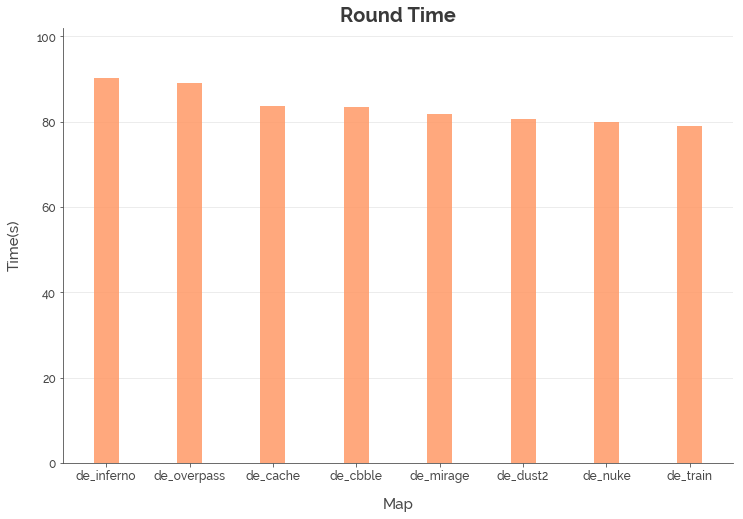

In [4]:
# Compute statistics for all maps
map_time = all_data.groupby('map')[['round_time']].median().sort_values('round_time', ascending=False)

# Plot
# CODE FOR GRAPHICS NOT INCLUDED

The median round time was just **81 seconds**. This is what I love about Dust2 - it's fast paced, and you get more time as a live player than a spectator. In the histogram below, note also how some rounds appeared to have lasted longer than 115 seconds. This is strange considering what we know about the time for competitive matches (round time of 1 minute and 55 seconds). Having spotted this peculiarity, we should raise questions about the quality of the data.

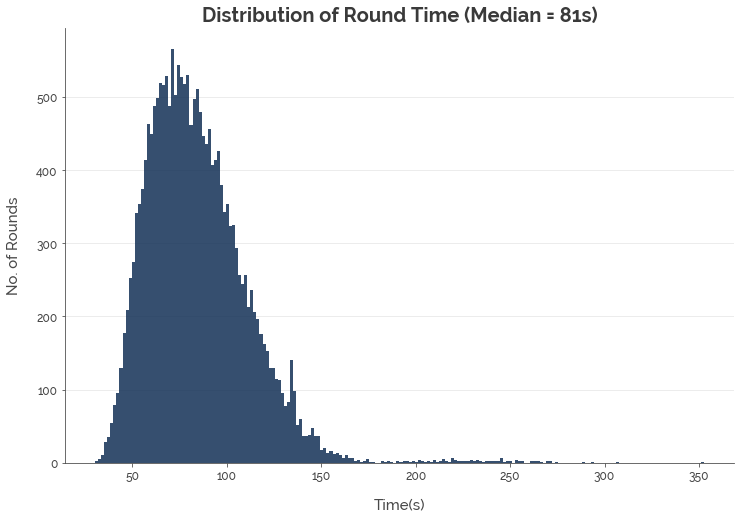

In [5]:
# CODE FOR GRAPHICS NOT INCLUDED

## Timing of Kills
While the overall distribution of round time gives us a broad overview of how quickly teams achieve the map objectives, it does not tell us much about *when* the action occurs. We need to dive into kill data to understand when teams make their plays.

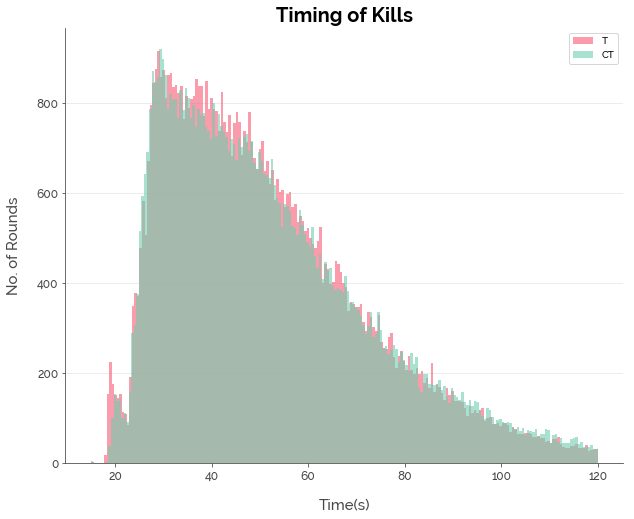

In [6]:
# Get timing of first kill for each round
kill_timing = kill_data[['seconds', 'att_side']]

# CODE FOR GRAPHICS NOT INCLUDED

### Pre-Round
First, we notice that there are effectively no kills inside 15 seconds. This is because the freezetime for competitive games is 15 seconds.  
  
### Early Phase
Early in the round, we see a small peak in the number of kills at approximately 20 seconds. This can be explained by the infamous B rush - a basic strategy in the T repertoire where the entire Terrorist team (if not, most of the Ts) runs from the spawn point straight into the B site. The strategy works because the Ts effectively reduce their distance to the enemy, enabling cheaper weapons like pistols and SMGs to become more effective. It takes approximately 18 seconds for the first man to reach the entrance to B through the tunnels from T Spawn, which explains why there are numerous data points concentrated around the 18 second mark for the Ts, and a response around the 20-second mark from the CTs (presumably re-frags).  
  
### End Phase
We address the end phase of a round first, because the middle phase of a round requires more data. Towards the end of the round, teams typically scale back their attempts to hunt down enemy players, be it to re-capture a bomb site to defuse the bomb or finish the opposing team off. This makes sense because surviving would conserve the team's finances.
  
### Middle Phase
It is much more difficult to label the peak at 30 seconds with an event. By that time, the players could have reached any part of the map. What we can infer is that the Ts typically make an attempt to capture a bomb site after the 25-second mark. To shed more light on what happens during this phase, we examine kill data **before and after** the bomb is planted. We don't have data on the timing of bomb plants. We only know whether kills occurred before or after that, but it is sufficient.

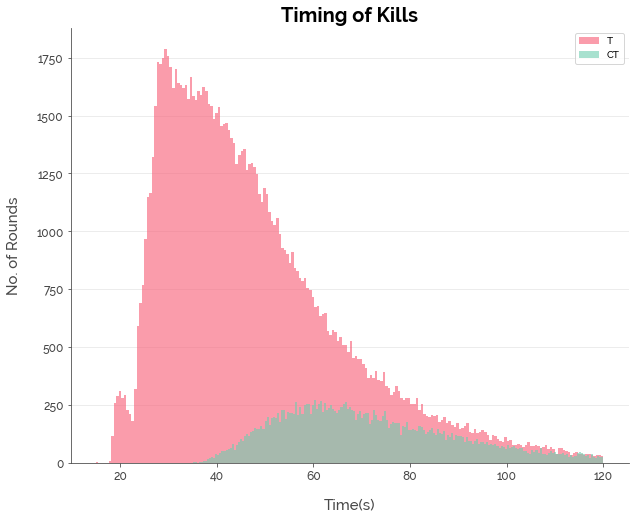

In [7]:
# Get timing of first kill for each round
kill_timing = kill_data[['seconds', 'is_bomb_planted']]

# CODE FOR GRAPHICS NOT INCLUDED

We note that no kills (after the bomb was planted) occurred before 35 seconds, while the median timing for kills after bomb plants was 68 seconds. Assuming that the CTs take some time to respond and set themselves up (for slaughter), and taking into account the distribution of kills before the bomb is planted, we can infer that:  
  
* Attempts to take a bomb site are typically mounted approximately 30-40 seconds into the round.
* The bomb is typically planted approximately 50-60 seconds into the round.
  
If our assumptions are correct, bomb sites can be taken in approximately 10-30 seconds.

# Finances in CS:GO
We continue our analysis with the most important resource in the game: money. Rounds in the dataset have been labelled as **Pistol Rounds**, **Ecos**, **Semi-Ecos**, **Force Buys** and **Normal** rounds. I disagree with these labels because they do not specify which team the labels apply to. For example, a round may be tagged as an Eco round, but does this refer to the Ts or CTs?  
  
In addition, we observe several peculiarities:  
  
1. It is not possible that teams spent more than \$5,000 in pistol rounds.
2. In Eco, Semi-Eco and Force Buy rounds, there are two peaks: a peak between \$5,000 and \$15,000, and another one at approximately \$27,500.  
  
Clearly, this will have an impact on subsequent analyses. We should make some effort to clean the data.

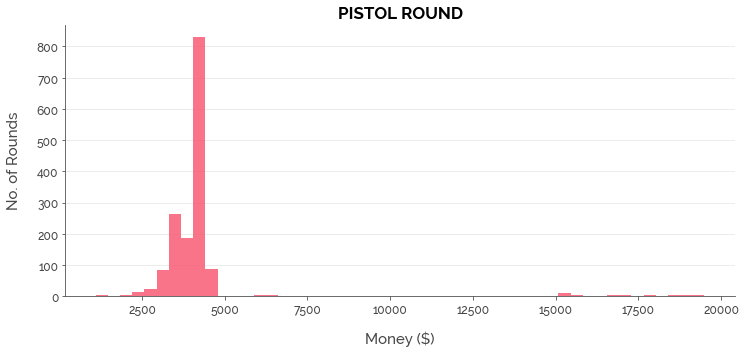

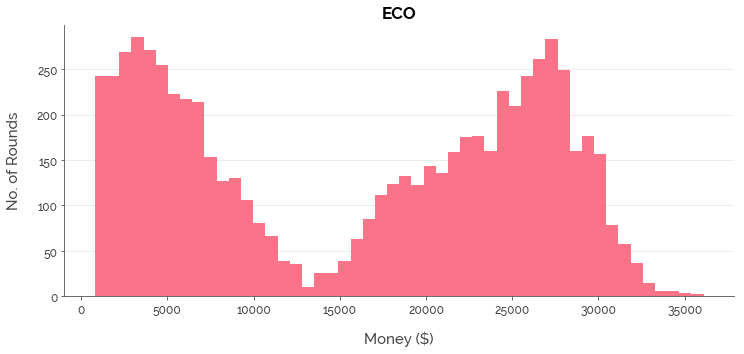

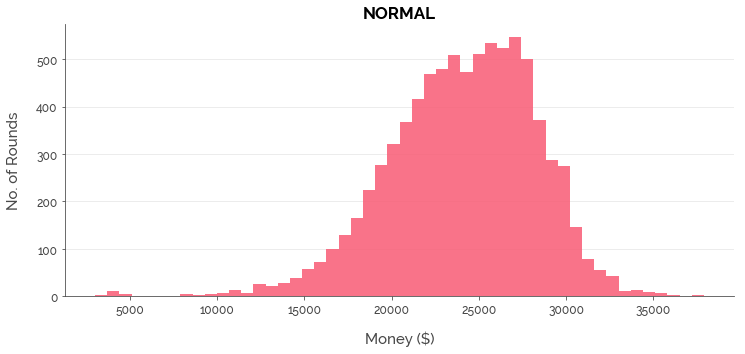

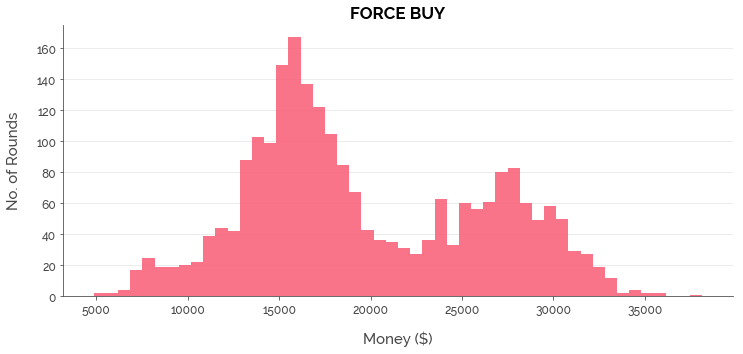

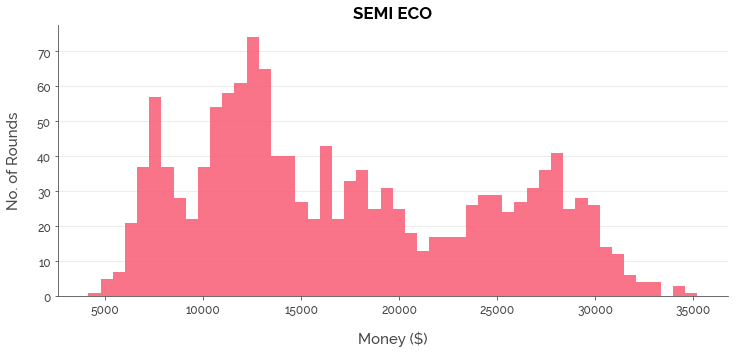

In [8]:
# CODE FOR GRAPHICS NOT INCLUDED

Hence, I created side-specific labels using simple heuristics:  
  
* The Pistol Round labels must be retained
* If the CT(T) equipment value is *lower* than that of T(CT), the Eco / Semi-Eco / Force Buy label applies to CT(T) and the Anti-Eco label applies to T(CT)
* All other rounds must be Normal rounds  
  
Notice that I added an Anti-Eco label. These are rounds in which a team was playing against opponents who were Eco-ing. 

In [9]:
# Compute equipment value difference
dust2['eqdiff'] = dust2['t_eq_val'] - dust2['ct_eq_val']

# First, we create a column of missing values
dust2['ct_round_type'] = np.nan

# Second, we fill in the pistol round labels
dust2['ct_round_type'][dust2.round_type=='PISTOL_ROUND'] = 'PISTOL_ROUND'

# Third, we fill in the Eco / Semi-Eco / Force Buy labels
dust2['ct_round_type'][(dust2.eqdiff > 0) & ((dust2.round_type=='ECO') | (dust2.round_type=='SEMI_ECO') | 
                                             (dust2.round_type=='FORCE_BUY'))] = dust2.round_type[(dust2.eqdiff > 0) & ((dust2.round_type=='ECO') | (dust2.round_type=='SEMI_ECO') | 
                                             (dust2.round_type=='FORCE_BUY'))]

# Fourth, we fill in the new Anti-Eco label
dust2['ct_round_type'][(dust2.eqdiff < 0) & ((dust2.round_type=='ECO') | (dust2.round_type=='SEMI_ECO'))] = 'ANTI_ECO'

# Finally, we fill in the remaining missing values with Normal labels
dust2['ct_round_type'] = dust2['ct_round_type'].fillna('NORMAL')

# Apply the same transformations to the T-side
dust2['t_round_type'] = np.nan
dust2['t_round_type'][dust2.round_type=='PISTOL_ROUND'] = 'PISTOL_ROUND'
dust2['t_round_type'][(dust2.eqdiff < 0) & ((dust2.round_type=='ECO') | (dust2.round_type=='SEMI_ECO') | 
                                             (dust2.round_type=='FORCE_BUY'))] = dust2.round_type[(dust2.eqdiff < 0) & ((dust2.round_type=='ECO') | (dust2.round_type=='SEMI_ECO') | 
                                             (dust2.round_type=='FORCE_BUY'))]
dust2['t_round_type'][(dust2.eqdiff > 0) & ((dust2.round_type=='ECO') | (dust2.round_type=='SEMI_ECO'))] = 'ANTI_ECO'
dust2['t_round_type'] = dust2['t_round_type'].fillna('NORMAL')

Note also that the equipment values for pistol rounds look odd. We should not be seeing values greater than $5,000 because each player starts with $1,000, and pistol rounds are the first round in any match. We can correct this by simply dumping them into the Force Buy category because that's where a bulk of the equipment values should lie. In addition, Force Buys typically follow a pistol round. Thus, data entry errors could have mistakenly labelled Force Buys as pistol rounds.

In [10]:
# Change the round type for all rounds with equipment value $5000+ to FORCE_BUY
dust2['t_round_type'][(dust2.t_round_type == 'PISTOL_ROUND') & (dust2.t_eq_val >= 5000)] = 'FORCE_BUY'
dust2['ct_round_type'][(dust2.ct_round_type == 'PISTOL_ROUND') & (dust2.ct_eq_val >= 5000)] = 'FORCE_BUY'

The distributions make more sense now:  

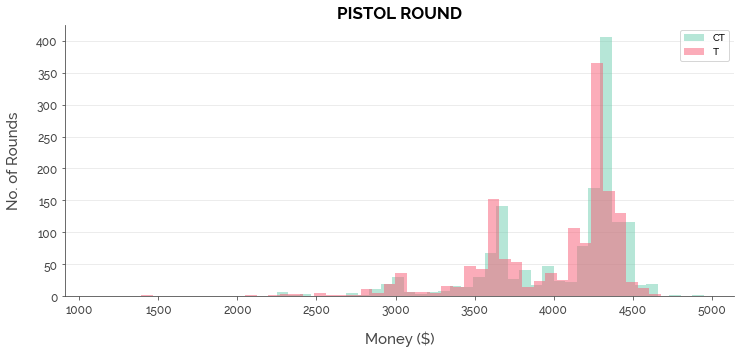

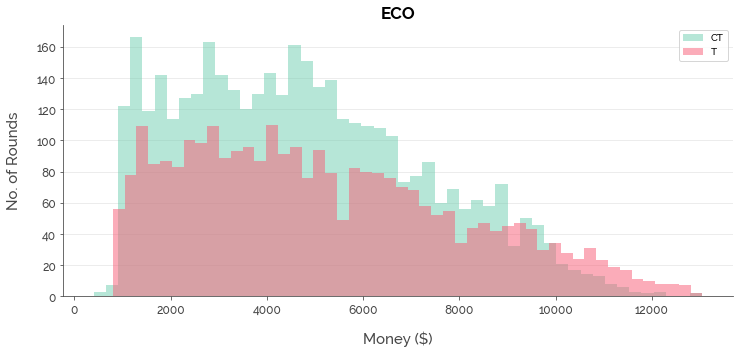

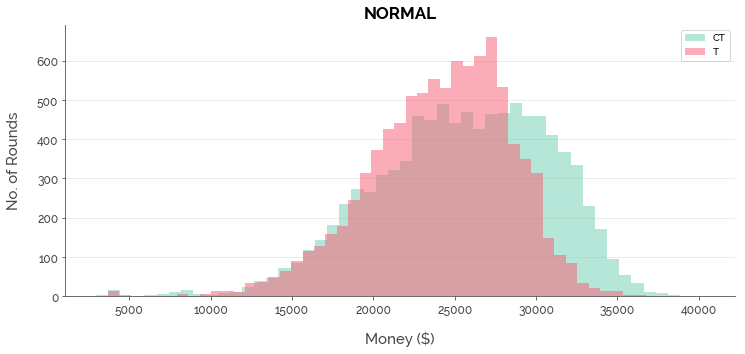

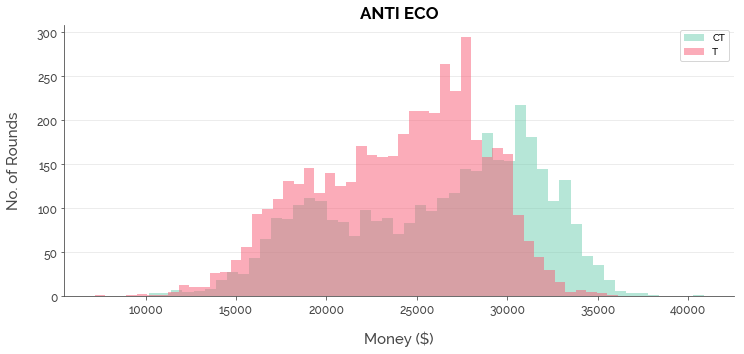

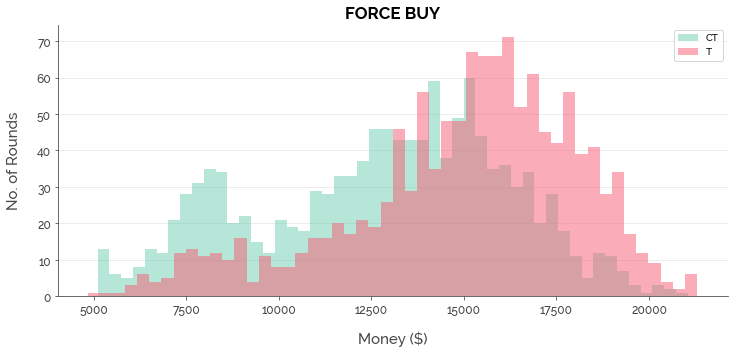

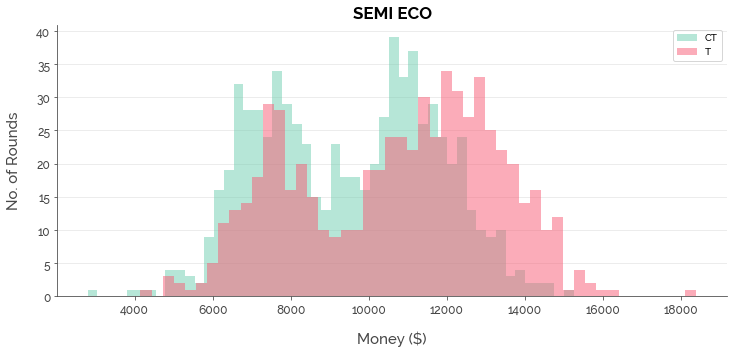

In [11]:
# CODE FOR GRAPHICS NOT INCLUDED

We explain two observations here:  
  
#### 1. Different Expenditure Levels
The CTs spend more money on Normal and Anti-Eco rounds, and generally save more on Ecos, Semi-Ecos and Force Buys. This is because the CT rifles are generally more expensive. Therefore, in non-buy rounds, it makes sense to save more money.  
  
#### 2. Dual Peaks in Spending
It might seem that Force Buy and Semi-Eco rounds are incorrectly labelled because there are two peaks in the equipment value data. However, consider the following two scenarios:

1. A team is wiped out during the previous round, but they have some money remaining. This round, they buy high-end pistols, kevlar, and grenades.
2. In the previous round, surviving team members pick up weapons or save their current weapons, while the rest of their teammates are dead and bankrupt. This round, their bankrupt teammates can choose to either stick with lousy equipment or bolster their firepower by exhausting their finances.  
  
Scenario 1 corresponds to the peak on the left, where each member of the team has low-value equipment. Scenario 2 corresponds to the peak on the right, where 1 or 2 members of the team have salvaged a high-value weapon, while the others either buy the best weapon they can, or stay on lousy equipment. Either way, the **team's** total equipment value is relatively high because of the salvaged weapons.
  
It is worth noting that Scenario 2 occurs extremely often. When the opponents have a huge manpower advantage, positional advantage, or both during a round, teams typically choose to **save** by running to a safe, defensible location to run the clock down, taking their existing weapons or stolen weapons with them to the next round. This explains why Force Buy and Semi-Eco rounds have low peaks (Scenario 1) and high peaks (Scenario 2).

# Map Bias: Does Dust2 Favour a Side?
Finally, we examine map bias: whether Ts or CTs have an edge on Dust2. We expect that Ts and CTs have an approximately equal win rate of 50%. However, the truth is that the T-side bias on Dust2 is the highest among all maps in the dataset. Thus, teams looking to win should capitalise on their T-side half, and casual players like me ought to play on T-side more often to stand a better chance of winning.

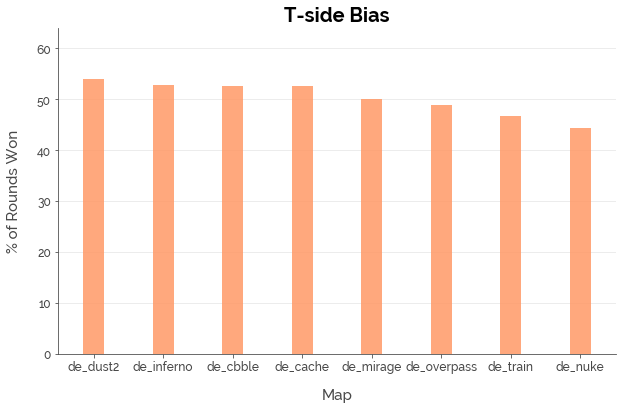

In [12]:
# Compute statistics for all maps
map_bias = all_data.groupby('map')[['t_score']].mean().sort_values('t_score', ascending=False)

# CODE FOR GRAPHICS NOT INCLUDED

Overall, as shown in the plot below, the Ts won approximately 53.8% of rounds, while CTs won only 46.2%. Given the large sample of 20,225 rounds, it is fair to say that there is a T-side bias. But, let's investigate further.

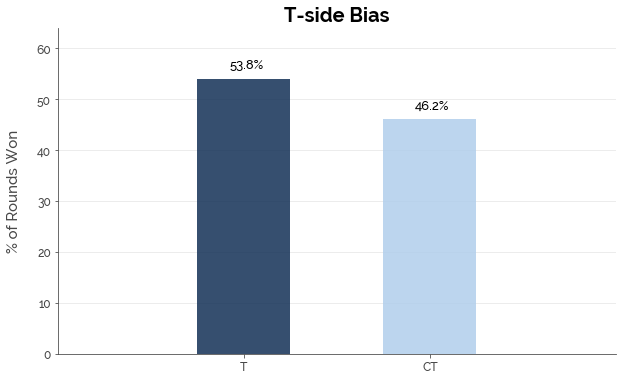

In [13]:
# CODE FOR GRAPHICS NOT INCLUDED

## Pistol Rounds
Pistol rounds are arguably the best for determining bias. This is because firepower is approximately equal, and therefore, map characteristics (which in turn affect tactics) become more important. Here, we see that the Ts won significantly more rounds than the CTs.

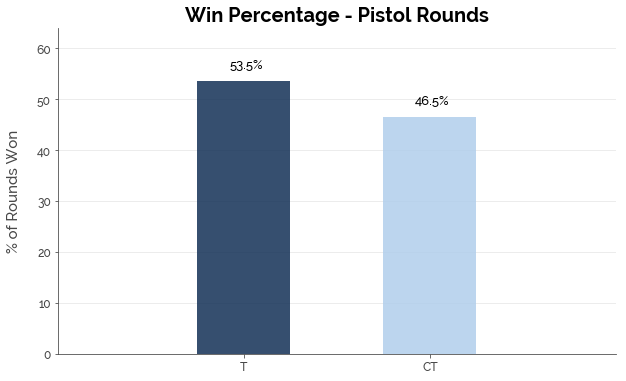

In [14]:
# Compute pistol round scores
round_pistol = dust2[(dust2.t_round_type == 'PISTOL_ROUND') & (dust2.ct_round_type == 'PISTOL_ROUND')].copy()

# CODE FOR GRAPHICS NOT INCLUDED

## Normal Rounds
Normal rounds are the next best for investigating bias because the firepower of each team should be approximately equal, although the variance of the difference in equipment values is larger. Here, we see a smaller bias in favour the Ts, but a bias nonetheless.

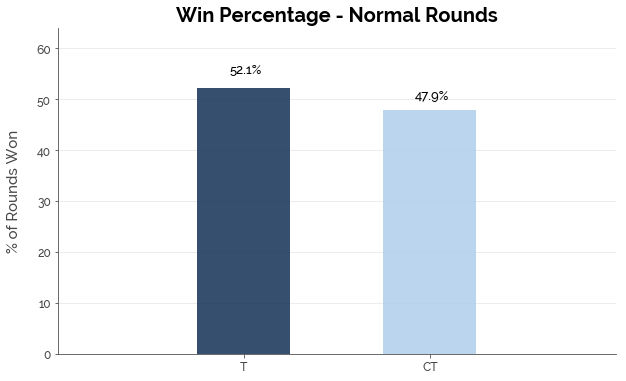

In [15]:
# Compute pistol round scores
round_normal = dust2[(dust2.t_round_type == 'NORMAL') & (dust2.ct_round_type == 'NORMAL')].copy()

# CODE FOR GRAPHICS NOT INCLUDED

## Anti-Eco Rounds
Next, we examine the proportion of Anti-Eco rounds won. The Ts did 3% better on their Anti-Eco rounds than the CTs. Note that the percentages don't add up to 100%, because, unlike normal rounds and pistol rounds, Ts and CTs play Anti-Eco rounds at different times - these by definition require them to play against a team that has chosen to go Eco.

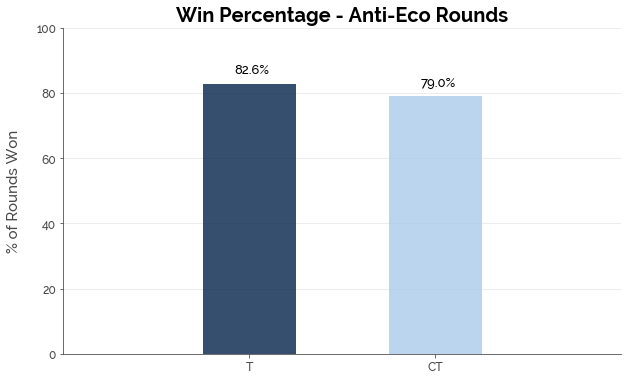

In [16]:
# Compute pistol round scores
round_ae = [dust2[dust2.t_round_type == 'ANTI_ECO'].t_score.mean()*100,
                dust2[dust2.ct_round_type == 'ANTI_ECO'].ct_score.mean()*100]

# CODE FOR GRAPHICS NOT INCLUDED

## Eco Rounds
The Ts also won 2.5% more of their Eco rounds than the CTs, possibly because the map allows Ts to set up strategies that allow them to get close to CTs and beat them in close proximity battles using pistols or SMGs.

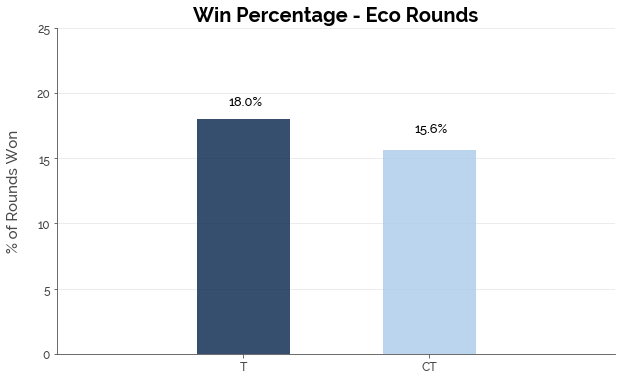

In [17]:
# Compute pistol round scores
round_eco = [dust2[dust2.t_round_type == 'ECO'].t_score.mean()*100,
                dust2[dust2.ct_round_type == 'ECO'].ct_score.mean()*100]

# CODE FOR GRAPHICS NOT INCLUDED

## Semi-Eco and Force Buys
These are where the biggest differences are. Ts won approximately 8% more on their Semi-Eco and Force Buy rounds than the CTs. I can only guess that Semi-Eco and Force Buy rounds are run with the same strategies as Eco rounds. The difference is that these rounds afford the Ts higher firepower, making the Ts more effective than in Eco rounds.

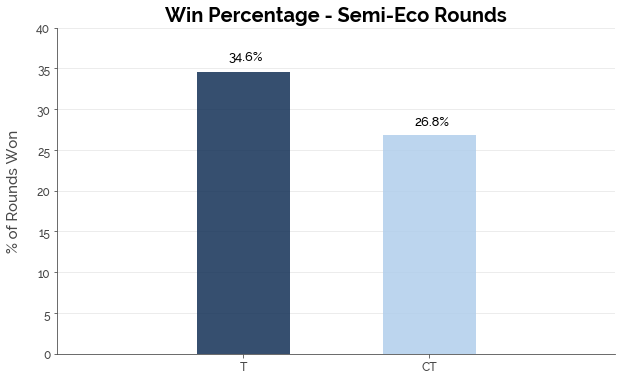

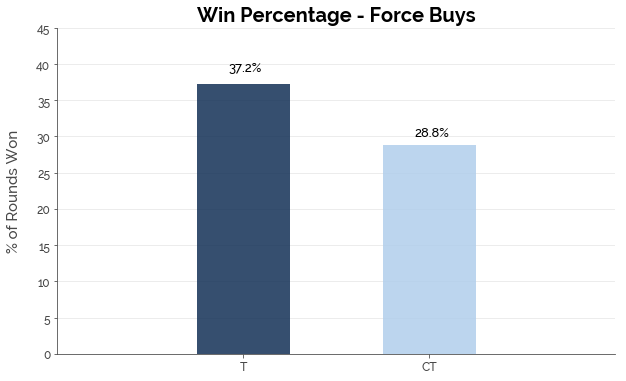

In [18]:
# Compute pistol round scores
round_se = [dust2[dust2.t_round_type == 'SEMI_ECO'].t_score.mean()*100,
                dust2[dust2.ct_round_type == 'SEMI_ECO'].ct_score.mean()*100]

# CODE FOR GRAPHICS NOT INCLUDED

# Compute pistol round scores
round_fb = [dust2[dust2.t_round_type == 'FORCE_BUY'].t_score.mean()*100,
                dust2[dust2.ct_round_type == 'FORCE_BUY'].ct_score.mean()*100]

# CODE FOR GRAPHICS NOT INCLUDED

# Conclusion [TLDR]
Here's what we learned:
  
1. Dust2 is a fast map. The median round time is approximately 81 seconds.
2. If you're a CT, time your responses (smokes, incendiaries, and movement) accordingly:  
    1. B-rushes typically occur at approximately 18 seconds. 
    2. Attempts on a bomb site are typically mounted at approximately 30-40 seconds.
    3. The bomb is typically planted at approximately 50-60 seconds.  
3. We extracted more accurate round type labels from the data. In general, we found that teams spend:  
    1. Less than \$5,000 on pistol rounds
    2. Up to \$12,000 on Eco rounds
    3. Upwards of \$15,000 on Normal and Anti-Eco rounds
    4. Between \$6,000 and \$20,000 on Force Buy rounds
    5. Between \$6,000 and \$15,000 on Semi-Eco rounds  
4. The statistics show that Dust2 favours the Ts. They do especially well on Semi-Eco rounds and Force Buys.  
  
In the next post, we analyse the popular and advantageous angles covered by the Ts and CTs through visualisations.